## Part 1 - Data Analysis and Bayes Nets

### 1) Data Visualization and Exploration

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3,5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
# Common imports
import numpy as np
import pandas as pd
import os
import cv2  # OpenCV Python library for computer vision

# to make this notebook's output stable across runs
np.random.seed(42)

In [4]:
# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

Loading only the training set for Part 1 of the coursework

In [6]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [7]:
x_train, y_train = load_train_data()

In [8]:
x_train.shape

(9690, 2304)

Analysing the dataset

In [9]:
#Checking the shape of the data
x_train.shape

(9690, 2304)

In [10]:
y_train.shape

(9690, 1)

### Preprocessing

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
x_train = np.asarray(x_train)

In [15]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 50)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [16]:

#variance thresholdimg 

from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.1, but this value depends on your data)
threshold_value = 0.15

x_train = pd.DataFrame(x_train)
# Instantiate the VarianceThreshold object
selector = VarianceThreshold(threshold=threshold_value)

# Assuming 'df' is your dataset
# Fit the selector to the data
selector.fit(x_train)

# Get the indices of features to keep
features_to_keep = selector.get_support(indices=True)

# Create a new DataFrame with selected features
df_high_variance = x_train.iloc[:, features_to_keep]


x_train = np.asarray(df_high_variance)





Visualising the dataset using graphs

In [17]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [18]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

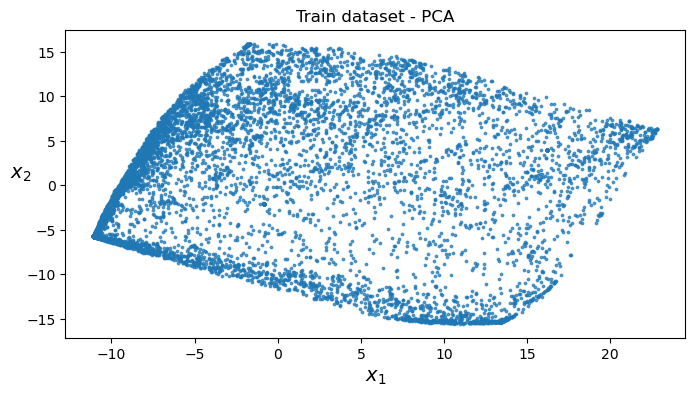

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

In [20]:


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)



In [21]:
from sklearn.metrics import accuracy_score

y_train = np.asarray(y_train)

cluster_to_majority_class = {}
for cluster_label in np.unique(cluster_labels):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_ground_truth_labels = y_train[cluster_mask].flatten()  # Flatten to 1D array
    majority_class = np.bincount(cluster_ground_truth_labels).argmax()
    cluster_to_majority_class[cluster_label] = majority_class

# Assign majority class labels to all data points in each cluster
cluster_assigned_labels = [cluster_to_majority_class[label] for label in cluster_labels]

# Evaluate clustering accuracy
accuracy = accuracy_score(y_train, cluster_assigned_labels)  # Compare with ground truth labels
print(f"Clustering Accuracy: {accuracy}")

Clustering Accuracy: 0.3306501547987616


In [22]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5443580403189067


In [23]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

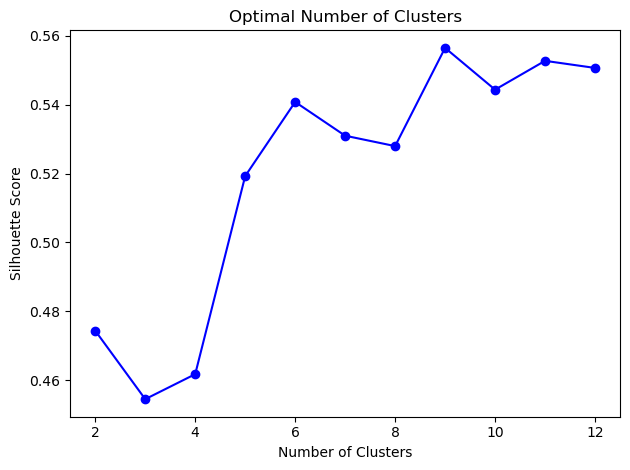

In [24]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()